In [1]:
# unrar
import shutil
from zipfile import ZipFile as zf

SEED = 101

with zf('Clinic.zip','r') as zin:
    zin.extractall()
    shutil.rmtree('25yjwbphn4-1')

In [2]:
# load data
import pandas as pd

df = pd.read_csv('Dataset.csv',encoding='utf-8')
medications = pd.read_csv('Medicationkey.csv')

df.rename(columns={'ID': 'Patient'}, inplace=True)
df.set_index('Patient',inplace=True)
medications.set_index('Medication', inplace=True)

# As-is, drug names have been shortened to alphabet letters, let's revert that
old_columns = medications.values.flatten()
new_columns = medications.index

for old, new in zip(old_columns, new_columns):
    df.rename(columns={old: new}, inplace=True)

In [3]:
# Get a sense of what features we are dealing with in this set
df.columns

Index(['GENDER', 'AGE', 'RACE/ETHNICITY', 'Diagnosis', 'MD', 'Assignment',
       'EMR', 'LOS', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE',
       'BUPROPION', 'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE',
       'CLONIDINE', 'DOXEPIN', 'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE',
       'FLUPHENAZINE', 'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL',
       'IMIPRAMINE', 'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE',
       'NORTRIPTYLINE', 'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE',
       'QUETIAPINE', 'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE',
       'ZIPRASIDONE', '# Psychotropic Medications', '# Administrations',
       'Therapeutic Guidances'],
      dtype='object')

In [4]:
# Clean unconventional column names
df.rename(columns={'# Administrations': 'Administrations'}, inplace=True)
df.rename(columns={'# Psychotropic Medications': 'Psychotropics'}, inplace=True)
df.rename(columns={'RACE/ETHNICITY': 'Ethnicity'}, inplace=True)

In [5]:
print('Checking for void values:')
df[df.columns[df.isnull().any()]].isnull().sum()

Checking for void values:


Assignment               41
Therapeutic Guidances    41
dtype: int64

In [26]:
'''
My strategy: 
Fill NaN with the most frequent value for each category
Note: mode() is the same as doing df[c].value_counts().index[0]
'''
df["Assignment"].fillna(df["Assignment"].mode().iloc[0], inplace=True)
df["Therapeutic Guidances"].fillna(df["Therapeutic Guidances"].mode().iloc[0], inplace=True)

# TODO convert categories to num so .corr() can detect them


'G'

In [7]:
df.groupby(['RAR']).count().transpose().head(1)

RAR,0,1
GENDER,1358,142


Discharged people : 1358 Recurrent people: 142 with a 9.56 imbalance


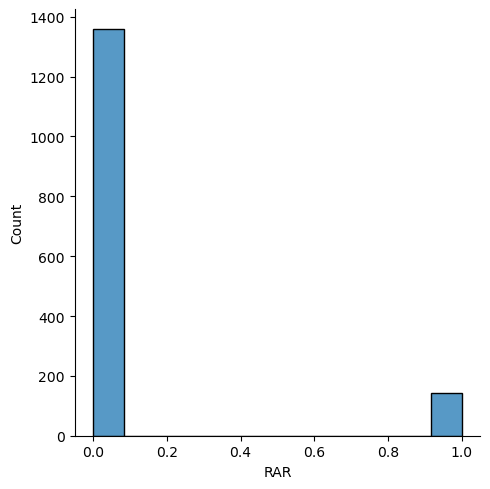

In [8]:
# Understanding data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

discharged_ppl,recurrent_ppl = df['RAR'].value_counts()
imbalance_ratio = np.around(discharged_ppl / recurrent_ppl,2)
print(f'Discharged people : {discharged_ppl} Recurrent people: {recurrent_ppl} with a {imbalance_ratio} imbalance')
sns.displot(df['RAR'])

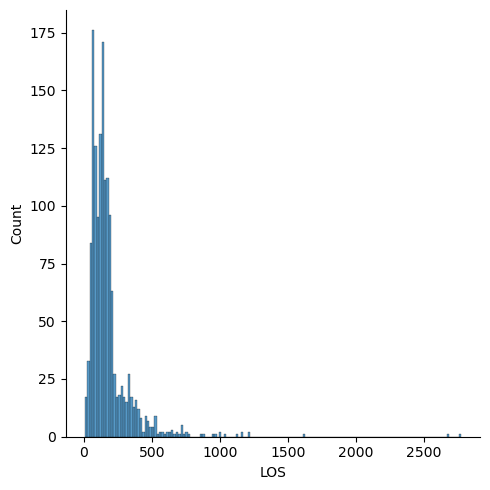

count    1500.000000
mean      176.520667
std       174.259930
min         6.000000
25%        90.000000
50%       138.000000
75%       191.250000
max      2776.000000
Name: LOS, dtype: float64


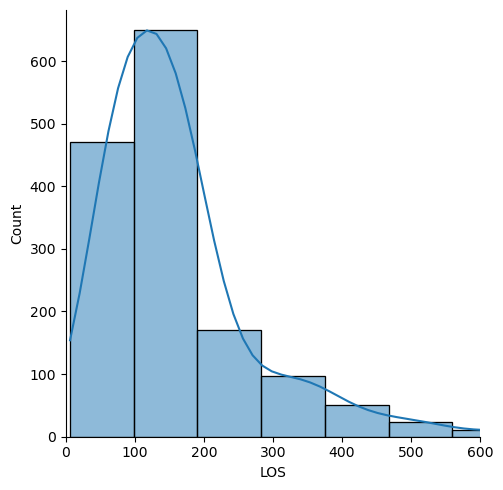

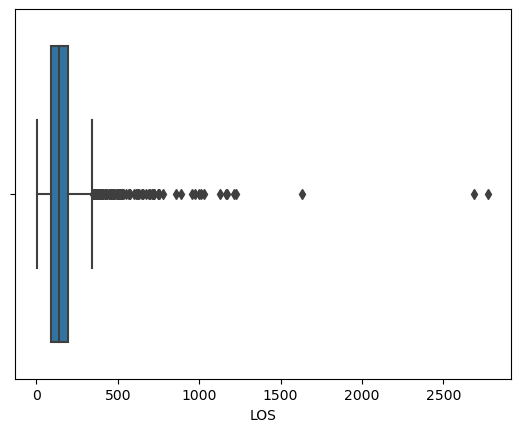

In [9]:
# Let's try to focus on another outcome

sns.displot(df['LOS'])
plt.show()
# Most patients don't stay more than 200 days
print(df['LOS'].describe())
sns.displot(data=df,x='LOS',bins=30,kde=1)
plt.xlim(0,600)
plt.show()
# Possibly detecting outliers
sns.boxplot(data=df,x='LOS')
plt.show()

In [10]:
# Considering ... I have opted for dropping outliers above a year of LOS (365d)
YEAR = 365
n_leftover_patients = df[df['LOS']<=YEAR].to_numpy().shape[0]
n_starting_patients = df.shape[0]

percentage = (n_leftover_patients / n_starting_patients) * 100

# Drop the columns
df.drop(df[df['LOS'] > YEAR].index,inplace=True)

print("Percentage of patients retained: {:.2f}%".format(percentage))
print(f"Now set has {df.shape[0]} patients")

Percentage of patients retained: 92.07%
Now set has 1381 patients


<Axes: xlabel='Ethnicity', ylabel='LOS'>

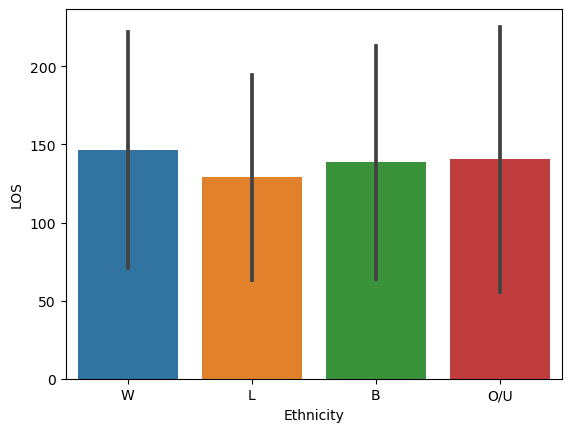

In [11]:
# White patients tend to vary most and have on avg the majority of LOS
sns.barplot(data=df, x='Ethnicity', y='LOS', estimator=np.mean, errorbar='sd')

<Axes: xlabel='LOS', ylabel='Administrations'>

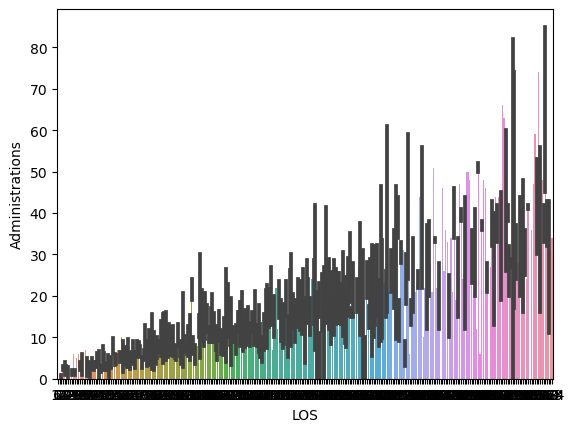

In [12]:
# Here we cannot see the number of people who fall into these ranges but rather only how total drug intake + days in clinic are  correlated
sns.barplot(data=df,x='LOS',y='Administrations')

C:\Users\W\AppData\Local\Temp\ipykernel_28936\495824401.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = df.corr().nlargest(26, 'LOS')['LOS'].sort_values(ascending=False).index


<Axes: >

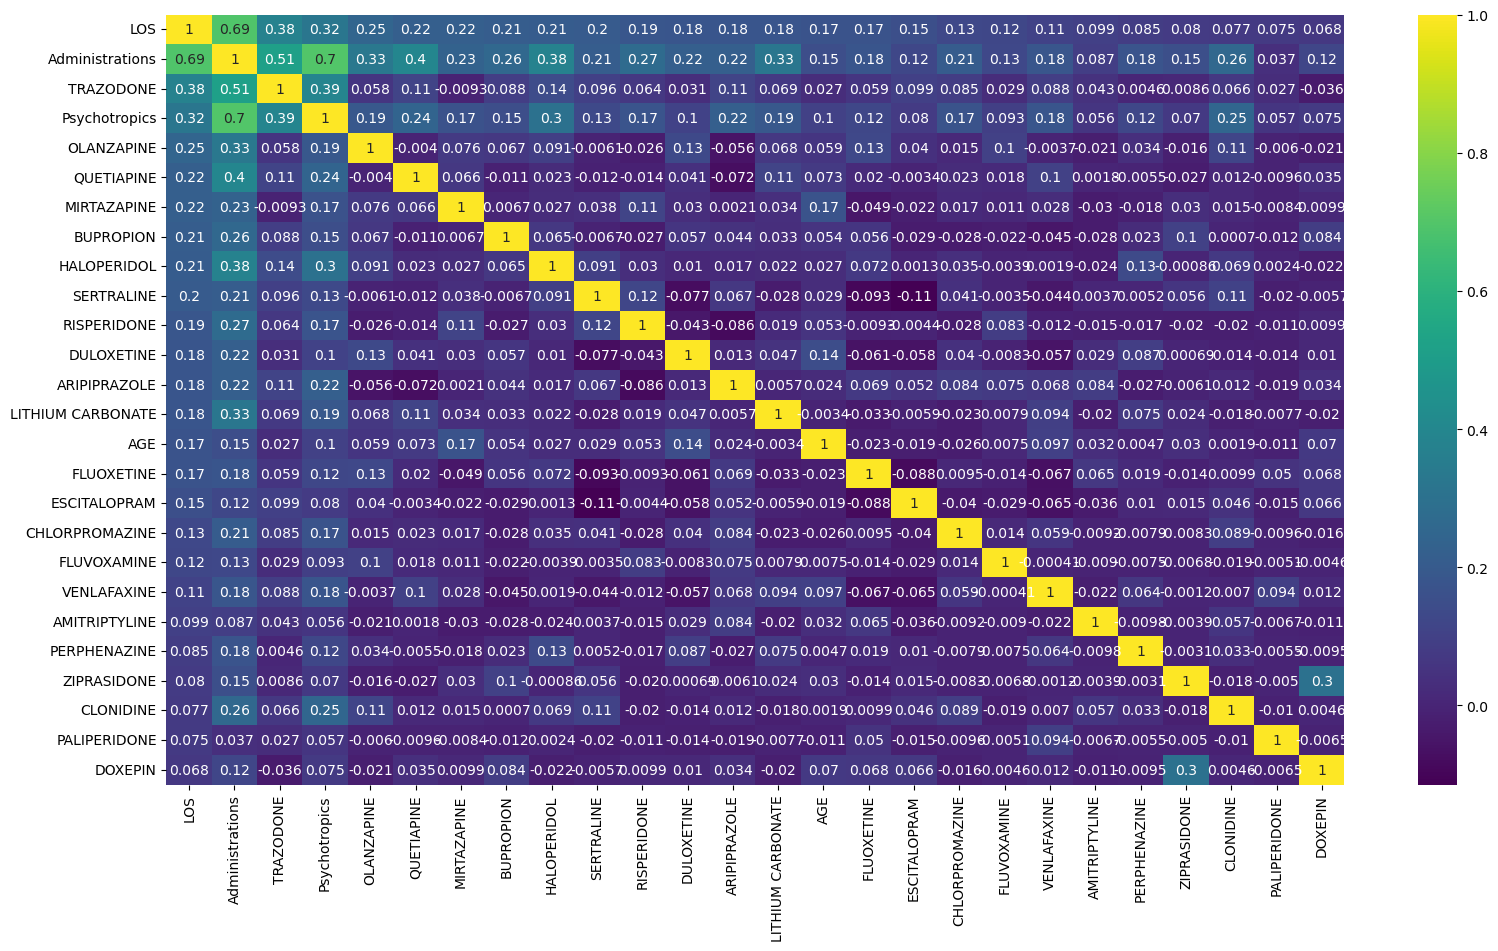

In [13]:
# There seems to be a correlation between the length of stay (LOS) and the amount of medications patients had to take
# Let's corroborate that presumption by plotting a heatmap!
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(19,10),dpi=100)
cols = df.corr().nlargest(26, 'LOS')['LOS'].sort_values(ascending=False).index
sns.heatmap(df[cols].corr(),annot=True,cmap='viridis')

In [14]:
# Too many features, isn't it? 

def clean_useless_cols(df, y_label):
    print('#########################')
    print(f'starting with {df.columns.size} cols')
    print('#########################')
    print(df.corr().nlargest(df.columns.size, y_label)
          [y_label].sort_values(ascending=True))
    irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()
    ir_cols_list = irrelevant_cols[irrelevant_cols[y_label]].index
    print('\n#########################')
    print('irrelevant cols found (constants):')
    print('#########################')
    print(df[ir_cols_list].nunique())
    df.drop(ir_cols_list, axis=1, inplace=True)
    print('\n#########################')
    print(f'voila! set cleared. {df.columns.size} cols left to work with')
    print('#########################')

clean_useless_cols(df,'LOS')

#########################
starting with 42 cols
#########################
NORTRIPTYLINE       -0.019901
CLOMIPRAMINE        -0.000976
RAR                  0.010312
GUANFACINE           0.026295
IMIPRAMINE           0.032074
METHYLPHENIDATE      0.041370
ASENAPINE            0.045044
FLUPHENAZINE         0.060431
CITALOPRAM           0.063513
DOXEPIN              0.068335
PALIPERIDONE         0.074908
CLONIDINE            0.076759
ZIPRASIDONE          0.080478
PERPHENAZINE         0.084514
AMITRIPTYLINE        0.098733
VENLAFAXINE          0.107052
FLUVOXAMINE          0.124117
CHLORPROMAZINE       0.125161
ESCITALOPRAM         0.153404
FLUOXETINE           0.170308
AGE                  0.171953
LITHIUM CARBONATE    0.177309
ARIPIPRAZOLE         0.179489
DULOXETINE           0.181110
RISPERIDONE          0.185899
SERTRALINE           0.200051
HALOPERIDOL          0.205327
BUPROPION            0.211505
MIRTAZAPINE          0.217169
QUETIAPINE           0.219652
OLANZAPINE           0.245

C:\Users\W\AppData\Local\Temp\ipykernel_28936\691254445.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  print(df.corr().nlargest(df.columns.size, y_label)
C:\Users\W\AppData\Local\Temp\ipykernel_28936\691254445.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  irrelevant_cols = pd.DataFrame(df.corr()[y_label]).isna()


# WIP

In [15]:
# Let's get our hands dirty
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE,RFECV
from sklearn.model_selection import train_test_split

clf = DecisionTreeClassifier(random_state=101)
OG_X = df.drop('LOS', axis=1)
# ????
alternative_x_vraag = OG_X.select_dtypes('number')

DummyX = pd.get_dummies(OG_X,drop_first=True)
y = df['LOS']

# Error encountered! 
# The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
# X_train, X_test, y_train, y_test = train_test_split(
#     OG_X, y, random_state=101, shuffle=1, test_size=0.3, stratify=y)

# TODO Solution: Combine values so you don't end up with single datapoints for very similar ranges

In [16]:
# test...

from sklearn.linear_model import ElasticNetCV

DummyX.columns
# TODO continue cleaning OR feed to ensemble / nn

Index(['AGE', 'RAR', 'AMITRIPTYLINE', 'ARIPIPRAZOLE', 'ASENAPINE', 'BUPROPION',
       'CHLORPROMAZINE', 'CITALOPRAM', 'CLOMIPRAMINE', 'CLONIDINE', 'DOXEPIN',
       'DULOXETINE', 'ESCITALOPRAM', 'FLUOXETINE', 'FLUPHENAZINE',
       'FLUVOXAMINE', 'GUANFACINE', 'HALOPERIDOL', 'IMIPRAMINE',
       'LITHIUM CARBONATE', 'METHYLPHENIDATE', 'MIRTAZAPINE', 'NORTRIPTYLINE',
       'OLANZAPINE', 'PALIPERIDONE', 'PERPHENAZINE', 'QUETIAPINE',
       'RISPERIDONE', 'SERTRALINE', 'TRAZODONE', 'VENLAFAXINE', 'ZIPRASIDONE',
       'Psychotropics', 'Administrations', 'GENDER_M', 'Ethnicity_L',
       'Ethnicity_O/U', 'Ethnicity_W',
       'Diagnosis_\tMDD, recurrent episode with anxious distress',
       'Diagnosis_Adjustment Disorder With Depressed Mood',
       'Diagnosis_Bipolar II Disorder', 'Diagnosis_Depression',
       'Diagnosis_Depression with suicidal ideation',
       'Diagnosis_Depressive Disorder NOS',
       'Diagnosis_Dissociative Disorder NOS', 'Diagnosis_MDD',
       'Diagnosis_MDD, 

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
# TODO Error Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']
# XX = LabelEncoder().fit_transform(OG_X.to_numpy().reshape(-1,1))

In [18]:
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay

def acc_confusion(clf,X,y):
    print('#########################')
    print(f'accuracy: {accuracy_score(y,clf.predict(X))}')
    print('#########################')
    ConfusionMatrixDisplay.from_estimator(clf,X,y)

In [19]:
clf = DecisionTreeClassifier().fit(alternative_x_vraag,y)

# Vanilla
clf.score(alternative_x_vraag,y)

0.9594496741491673

In [20]:
# Possible feature selection
# KBest
skb = SelectKBest(chi2, k=5).fit(X_train, y_train)
# Recurrent Feature Extraction 
rfe = RFE(clf,step=1).fit(X_train,y_train)
# Recurrent Feature Extraction with Cross-Validation
rfecv = RFECV(clf,step=1,scoring='accuracy',cv=5).fit(X_train,y_train)

SKBX_train = skb.transform(X_train)
SKBX_test = skb.transform(X_test)
pd.DataFrame({'ft': OG_X.columns, 'score': skb.scores_}
             ).sort_values('score', ascending=0)
print(f'SKB OG ft: {X_train.shape[1:]} | best ft: {SKBX_train.shape[1:]}')

RFEX_train = rfe.transform(X_train)
RFEX_test = rfe.transform(X_test)
rfe_df = pd.DataFrame({'ft':OG_X.columns,'ranking':rfe.ranking_}).sort_values('ranking')
keep_ft = rfe_df.loc[rfe_df['ranking']<2,'ranking'].count()
print(f'RFE now considering {keep_ft} cols')

RFECVX_train = rfecv.transform(X_train)
RFECVX_test = rfecv.transform(X_test)
print(f'RFECV says {X_train.columns[rfecv.support_]} ({rfecv.n_features_}) as best ft\'s to keep')

NameError: name 'X_train' is not defined